In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

## generate file

## functions 

In [2]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = RandomForestClassifier(n_estimators=100,max_features='sqrt').fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "rf_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


## main

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9583     ,    0.9874     ,    1.0000     ,    0.9787     
  1  ,    0.9881     ,    1.0000     ,    0.9916     ,    0.9726     ,    0.9861     
  1  ,    1.0000     ,    0.9718     ,    0.9916     ,    1.0000     ,    0.9857     
  2  ,    0.9940     ,    1.0000     ,    0.9958     ,    0.9861     ,    0.9930     
  2  ,    1.0000     ,    0.9577     ,    0.9874     ,    1.0000     ,    0.9784     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  4  ,    0.9641     ,    1.0000     ,    0.9748     ,    0.9221     ,    0.9595     
  4  ,    0.9880     ,    0.9718     ,    0.9832     ,    0.9718     ,    0.9718     
              prec

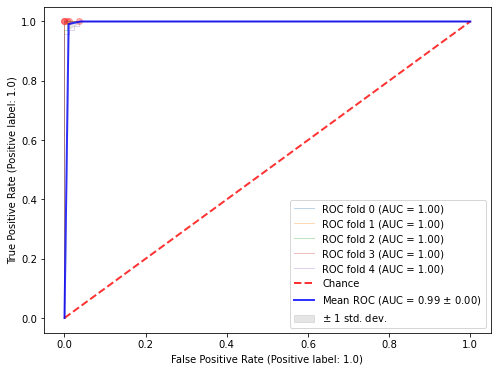

[1.0, 0.9999161636485581, 0.9998313232689551, 1.0, 0.9989879396137302]
0.9997470853062487
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9847     ,    0.9855     ,    0.9848     ,    0.9067     ,    0.9444     
  0  ,    0.9978     ,    0.9420     ,    0.9905     ,    0.9848     ,    0.9630     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9855     ,    0.9981     ,    1.0000     ,    0.9927     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9935     ,    1.0000     ,    0.9943     ,    0.9583     ,    0.9787     
  4  ,    0.9978     ,    1.0000     ,    0.9981     ,    0.9855     ,    0.9927     
  4  ,    0.99

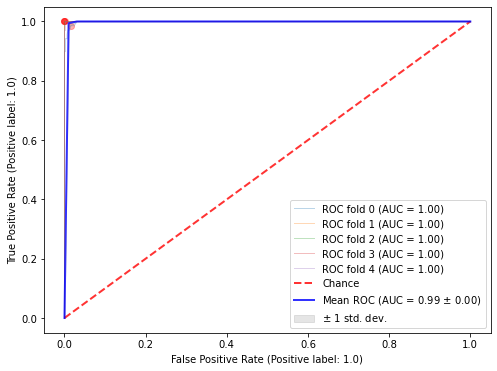

[0.9991001231410438, 1.0, 1.0, 1.0, 0.9999360613810742]
0.9998072369044235
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9958     ,    0.9948     ,    0.9957     ,    0.9598     ,    0.9770     
  0  ,    0.9974     ,    0.9896     ,    0.9967     ,    0.9744     ,    0.9819     
  1  ,    0.9921     ,    1.0000     ,    0.9928     ,    0.9275     ,    0.9624     
  1  ,    0.9958     ,    0.9948     ,    0.9957     ,    0.9598     ,    0.9770     
  2  ,    0.9932     ,    0.9948     ,    0.9933     ,    0.9363     ,    0.9646     
  2  ,    0.9953     ,    0.9896     ,    0.9948     ,    0.9548     ,    0.9719     
  3  ,    0.9974     ,    0.9948     ,    0.9971     ,    0.9745     ,    0.9845     
  3  ,    0.9968     ,    0.9948     ,    0.9967     ,    0.9695     ,    0.9820     
  4  ,    0.9842     ,    0.9896     ,    0.9847     ,    0.8636     ,    0.9223     
  4  ,    0.9979     ,    0.9

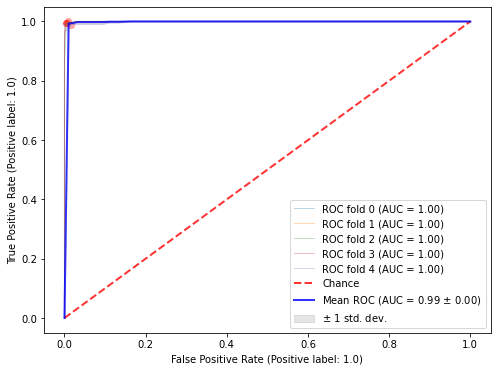

[0.9998044139530812, 0.9998577556022409, 0.9995281315651261, 0.9998276654411764, 0.9984530921743697]
0.999494211747199
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9991     ,    1.0000     ,    0.9992     ,    0.9904     ,    0.9952     
  0  ,    1.0000     ,    0.9903     ,    0.9992     ,    1.0000     ,    0.9951     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9955     ,    1.0000     ,    0.9959     ,    0.9537     ,    0.9763     
  3  ,    0.9973     ,    0.9903     ,    0.9967     ,    0.9714     ,    0.9808     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     , 

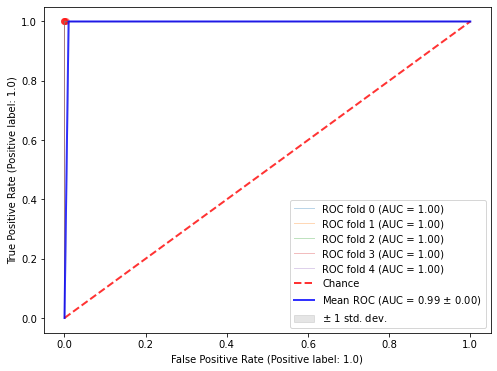

[0.9999956502070502, 1.0, 1.0, 0.9999608518634513, 1.0]
0.9999913004141003
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9825     ,    0.9952     ,    1.0000     ,    0.9912     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9825     ,    0.9952     ,    1.0000     ,    0.9912     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,   

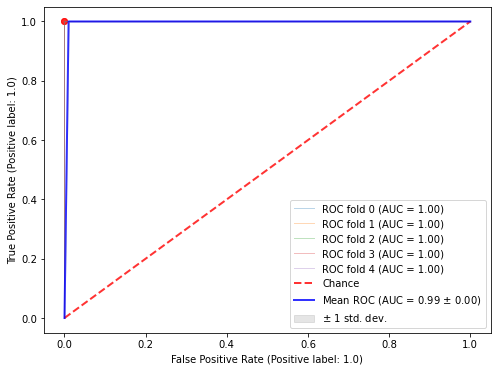

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9916     ,    0.9677     ,    0.9905     ,    0.8571     ,    0.9091     
  0  ,    0.9916     ,    0.9677     ,    0.9905     ,    0.8571     ,    0.9091     
  1  ,    0.9983     ,    0.9333     ,    0.9952     ,    0.9655     ,    0.9492     
  1  ,    0.9983     ,    0.9333     ,    0.9952     ,    0.9655     ,    0.9492     
  2  ,    0.9933     ,    1.0000     ,    0.9936     ,    0.8824     ,    0.9375     
  2  ,    0.9950     ,    0.9667     ,    0.9936     ,    0.9062     ,    0.9355     
  3  ,    0.9967     ,    1.0000     ,    0.9968     ,    0.9375     ,    0.9677     
  3  ,    0.9967     ,    0.9333     ,    0.9936     ,    0.9333     ,    0.9333     
  4  ,    0.9615     ,    1.0000     ,    0.9634     ,    0.5660     ,    0.7229     
  4  ,    0.9916     ,    0.9667     ,    0.9904     ,    0.8529     ,

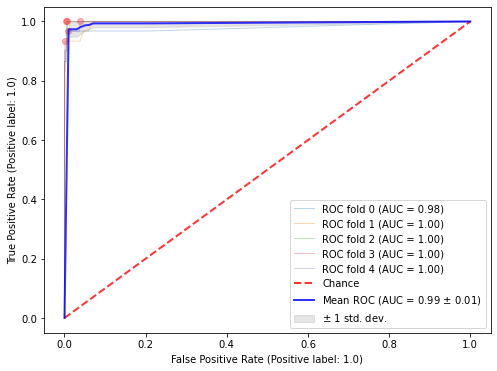

[0.9800409968712914, 0.9960144927536232, 0.9994425863991081, 0.9996098104793757, 0.9982998885172799]
0.9946815550041356
========== Patient_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9320     ,    0.9677     ,    0.9426     ,    0.8571     ,    0.9091     
  0  ,    0.9728     ,    0.8871     ,    0.9474     ,    0.9322     ,    0.9091     
  1  ,    0.9589     ,    0.9839     ,    0.9663     ,    0.9104     ,    0.9457     
  1  ,    0.9795     ,    0.9194     ,    0.9615     ,    0.9500     ,    0.9344     
  2  ,    0.9048     ,    1.0000     ,    0.9327     ,    0.8133     ,    0.8971     
  2  ,    0.9932     ,    0.8689     ,    0.9567     ,    0.9815     ,    0.9217     
  3  ,    0.9320     ,    0.9836     ,    0.9471     ,    0.8571     ,    0.9160     
  3  ,    0.9728     ,    0.8197     ,    0.9279     ,    0.9259     ,    0.8696     
  4  ,    0.9796     ,    0.9836     ,    0.9808     ,    0.9524  

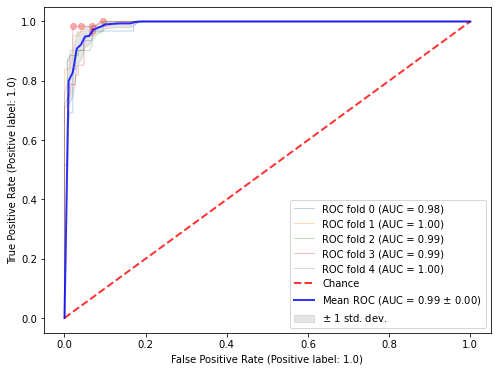

[0.9845841562431424, 0.995249668581529, 0.9904650384744063, 0.9882903981264637, 0.9958737593398015]
0.9908926041530686
========== Patient_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.7500     ,    0.9762     ,    1.0000     ,    0.8571     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9737     ,    1.0000     ,    0.9762     ,    0.8000     ,    0.8889     
  4  ,    0.9487     ,    1.0000     ,    0.9524     ,    0.6000   

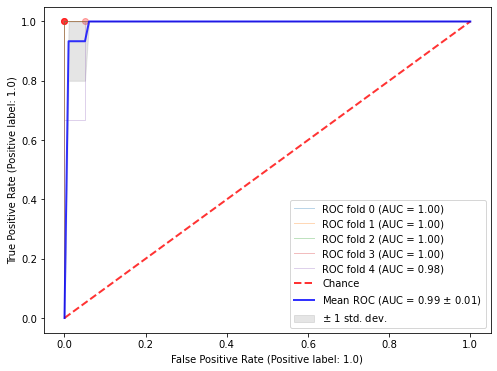

[1.0, 1.0, 1.0, 1.0, 0.982905982905983]
0.9965811965811966
========== Patient_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9924     ,    0.9615     ,    0.9909     ,    0.8621     ,    0.9091     
  0  ,    1.0000     ,    0.8462     ,    0.9927     ,    1.0000     ,    0.9167     
  1  ,    0.9981     ,    1.0000     ,    0.9982     ,    0.9630     ,    0.9811     
  1  ,    1.0000     ,    0.8077     ,    0.9909     ,    1.0000     ,    0.8936     
  2  ,    0.9924     ,    1.0000     ,    0.9927     ,    0.8621     ,    0.9259     
  2  ,    1.0000     ,    0.9200     ,    0.9964     ,    1.0000     ,    0.9583     
  3  ,    0.9847     ,    0.9600     ,    0.9836     ,    0.7500     ,    0.8421     
  3  ,    1.0000     ,    0.8400     ,    0.9927     ,    1.0000     ,    0.9130     
  4  ,    0.9943     ,    1.0000     ,    0.9945     ,    0.8929     ,    0.9434     
  4  ,    1.0000     ,    0.8000     ,   

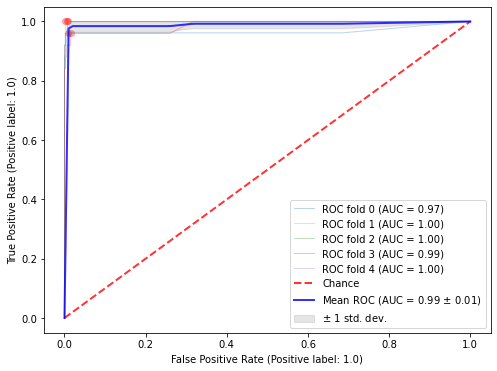

[0.9673113693190176, 0.9997058390939845, 0.9996564885496183, 0.9875572519083969, 0.9996946564885496]
0.9907851210719134
========== Patient_6_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  0  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  1  ,    0.9820     ,    1.0000     ,    0.9833     ,    0.8182     ,    0.9000     
  1  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  2  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  2  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000  

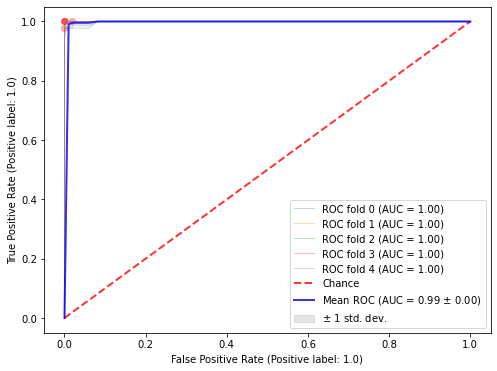

[0.9984384384384384, 0.9995995995995997, 0.9999197753710389, 1.0, 1.0]
0.9995915626818153
========== Patient_7_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9828     ,    0.9913     
  0  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  2  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  2  ,    1.0000     ,    0.9643     ,    0.9972     ,    1.0000     ,    0.9818     
  3  ,    0.9969     ,    1.0000     ,    0.9972     ,    0.9655     ,    0.9825     
  3  ,    1.0000     ,    0.9821     ,    0.9986     ,    1.0000     ,    0.9910     
  4  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9825     ,    0.9912     
  4  ,    

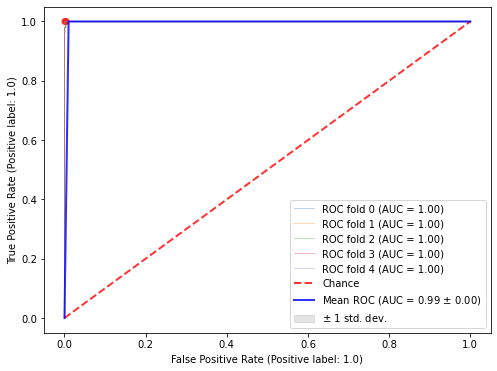

[0.9999729261425168, 1.0, 0.999972442680776, 0.999944885361552, 0.999944885361552]
0.9999670279092794
========== Patient_8_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9971     ,    0.9722     ,    0.9947     ,    0.9722     ,    0.9722     
  0  ,    0.9971     ,    0.9444     ,    0.9921     ,    0.9714     ,    0.9577     
  1  ,    0.9708     ,    1.0000     ,    0.9735     ,    0.7826     ,    0.8780     
  1  ,    0.9912     ,    0.9444     ,    0.9868     ,    0.9189     ,    0.9315     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9971     ,    1.0000     ,    0.9974     ,    0.9730     ,    0.9863     
  3  ,    0.9971     ,    0.9722     ,    0.9947     ,    0.9722     ,    0.9722     
  3  ,    0.9854     ,    0.9722     ,    0.9841     ,    0.8750     ,    0.9211     
  4  ,    0.9942     ,    0.8611     ,    0.9815     ,    0.9394     ,    0.8986    

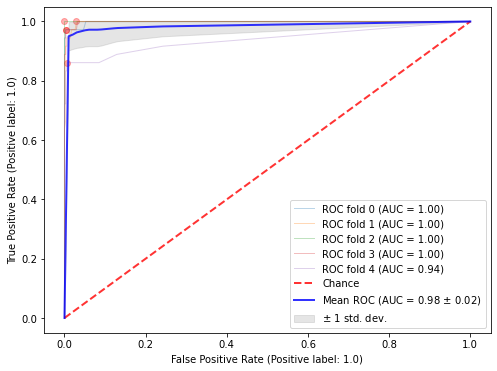

[0.9985380116959065, 0.9978476283300844, 1.0, 0.9989035087719298, 0.9396117608836907]
0.9869801819363223


In [3]:
file_list = [f for f in Path(dect_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample)
    print(aucs)
    print(np.mean(aucs))

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8379     ,    0.7308     ,    0.8327     ,    0.1863     ,    0.2969     
  0  ,    0.9824     ,    0.1923     ,    0.9442     ,    0.3571     ,    0.2500     
  1  ,    0.7031     ,    0.6923     ,    0.7026     ,    0.1059     ,    0.1837     
  1  ,    0.9863     ,    0.0769     ,    0.9424     ,    0.2222     ,    0.1143     
  2  ,    0.6953     ,    0.7308     ,    0.6970     ,    0.1086     ,    0.1891     
  2  ,    0.9805     ,    0.3462     ,    0.9498     ,    0.4737     ,    0.4000     
  3  ,    0.6934     ,    0.7600     ,    0.6965     ,    0.1080     ,    0.1891     
  3  ,    0.9766     ,    0.0400     ,    0.9330     ,    0.0769     ,    0.0526     
  4  ,    0.7168     ,    0.6800     ,    0.7151     ,    0.1049     ,    0.1818     
  4  ,    0.9844     ,    0.2000     ,    0.9479     ,    0.3846     ,    0.2632     
              prec

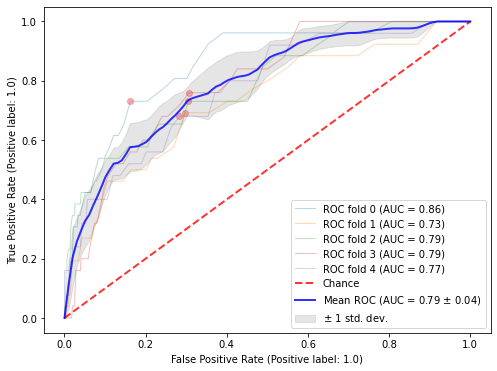

[0.8604642427884616, 0.73193359375, 0.7883864182692307, 0.7924609375, 0.77421875]
0.7894927884615385
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8689     ,    1.0000     ,    0.8789     ,    0.3860     ,    0.5570     
  0  ,    0.9532     ,    0.7955     ,    0.9412     ,    0.5833     ,    0.6731     
  1  ,    0.8949     ,    0.9333     ,    0.8979     ,    0.4286     ,    0.5874     
  1  ,    0.9756     ,    0.6889     ,    0.9533     ,    0.7045     ,    0.6966     
  2  ,    0.8705     ,    1.0000     ,    0.8806     ,    0.3947     ,    0.5660     
  2  ,    0.9644     ,    0.7333     ,    0.9464     ,    0.6346     ,    0.6804     
  3  ,    0.9437     ,    0.8667     ,    0.9377     ,    0.5652     ,    0.6842     
  3  ,    0.9681     ,    0.8222     ,    0.9567     ,    0.6852     ,    0.7475     
  4  ,    0.9062     ,    1.0000     ,    0.9135     ,    0.4737     ,    0.6429     
  4

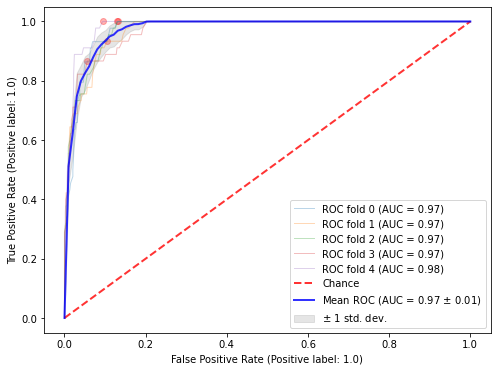

[0.9735274089206674, 0.9701063164477798, 0.9739003543881593, 0.9695851573900354, 0.9839066082968522]
0.9742051690886988
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9596     ,    0.8831     ,    0.9560     ,    0.5231     ,    0.6570     
  0  ,    0.9935     ,    0.7792     ,    0.9833     ,    0.8571     ,    0.8163     
  1  ,    0.9544     ,    0.9610     ,    0.9547     ,    0.5139     ,    0.6697     
  1  ,    0.9974     ,    0.7532     ,    0.9857     ,    0.9355     ,    0.8345     
  2  ,    0.9544     ,    0.8961     ,    0.9516     ,    0.4964     ,    0.6389     
  2  ,    0.9941     ,    0.7143     ,    0.9808     ,    0.8594     ,    0.7801     
  3  ,    0.9141     ,    0.8961     ,    0.9132     ,    0.3433     ,    0.4964     
  3  ,    0.9941     ,    0.6104     ,    0.9758     ,    0.8393     ,    0.7068     
  4  ,    0.9290     ,    0.8947     ,    0.9274     ,    0.3842     ,

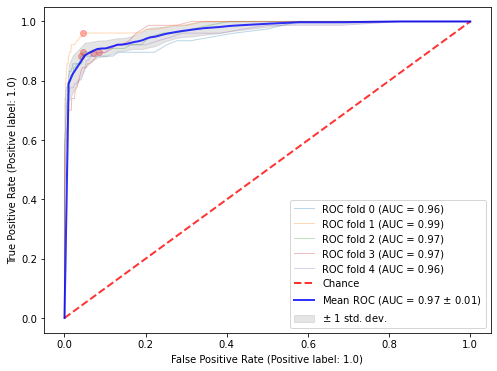

[0.9568367830086579, 0.9871355857683983, 0.9716965976731601, 0.9728464894480519, 0.959228515625]
0.9695487943046537
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9114     ,    0.9038     ,    0.9106     ,    0.5529     ,    0.6861     
  0  ,    0.9359     ,    0.8462     ,    0.9262     ,    0.6154     ,    0.7126     
  1  ,    0.8916     ,    0.9327     ,    0.8960     ,    0.5105     ,    0.6599     
  1  ,    0.9371     ,    0.8269     ,    0.9252     ,    0.6143     ,    0.7049     
  2  ,    0.8788     ,    0.8269     ,    0.8732     ,    0.4526     ,    0.5850     
  2  ,    0.9452     ,    0.7308     ,    0.9220     ,    0.6179     ,    0.6696     
  3  ,    0.8891     ,    0.8846     ,    0.8887     ,    0.4920     ,    0.6323     
  3  ,    0.9358     ,    0.7788     ,    0.9188     ,    0.5956     ,    0.6750     
  4  ,    0.8763     ,    0.8846     ,    0.8772     ,    0.4646     ,    

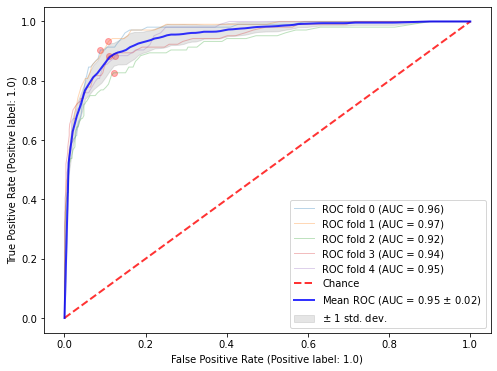

[0.961325533440918, 0.9663797740720818, 0.9181851802044111, 0.9430482003410825, 0.954913158603357]
0.94877036933237
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9792     ,    0.9688     ,    0.9785     ,    0.7561     ,    0.8493     
  0  ,    0.9854     ,    0.7812     ,    0.9727     ,    0.7812     ,    0.7812     
  1  ,    0.9771     ,    1.0000     ,    0.9785     ,    0.7442     ,    0.8533     
  1  ,    0.9917     ,    0.8438     ,    0.9824     ,    0.8710     ,    0.8571     
  2  ,    0.9583     ,    1.0000     ,    0.9609     ,    0.6154     ,    0.7619     
  2  ,    0.9854     ,    0.9062     ,    0.9805     ,    0.8056     ,    0.8529     
  3  ,    0.9958     ,    1.0000     ,    0.9961     ,    0.9412     ,    0.9697     
  3  ,    0.9958     ,    0.9688     ,    0.9941     ,    0.9394     ,    0.9538     
  4  ,    0.9646     ,    1.0000     ,    0.9668     ,    0.6531     ,    

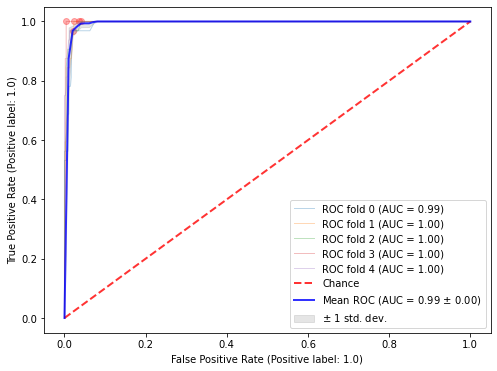

[0.9924479166666667, 0.9953125, 0.9963216145833333, 0.9981119791666666, 0.9974283854166667]
0.9959244791666666
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1

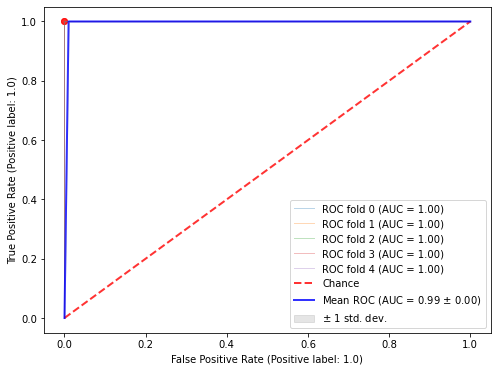

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.8947     ,    0.9697     ,    1.0000     ,    0.9444     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    0.9565     ,    0.9500     ,    0.9545     ,    0.9048     ,    0.9268     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

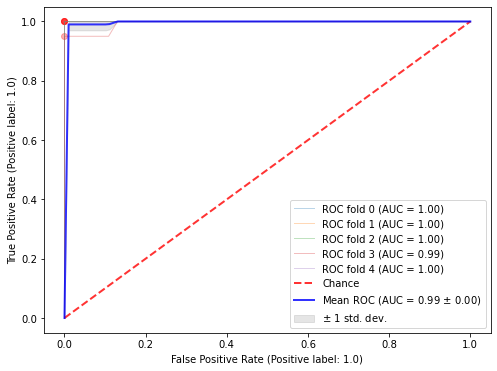

[1.0, 1.0, 1.0, 0.9940217391304348, 1.0]
0.9988043478260871


In [4]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))

# Logistic Regression

In [5]:
def train_pred_lr(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = LogisticRegression().fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "lr_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs

In [6]:
import warnings
warnings.filterwarnings("ignore")

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.5996     ,    0.9615     ,    0.6171     ,    0.1087     ,    0.1953     
  0  ,    0.7891     ,    0.5385     ,    0.7770     ,    0.1148     ,    0.1892     
  1  ,    0.6914     ,    0.7692     ,    0.6952     ,    0.1124     ,    0.1961     
  1  ,    0.8027     ,    0.4231     ,    0.7844     ,    0.0982     ,    0.1594     
  2  ,    0.7461     ,    0.8077     ,    0.7491     ,    0.1391     ,    0.2373     
  2  ,    0.7695     ,    0.7308     ,    0.7677     ,    0.1387     ,    0.2331     
  3  ,    0.7129     ,    0.7600     ,    0.7151     ,    0.1145     ,    0.1990     
  3  ,    0.8086     ,    0.6000     ,    0.7989     ,    0.1327     ,    0.2174     
  4  ,    0.6035     ,    0.9200     ,    0.6182     ,    0.1018     ,    0.1833     
  4  ,    0.7988     ,    0.4400     ,    0.7821     ,    0.0965     ,    0.1583     
              prec

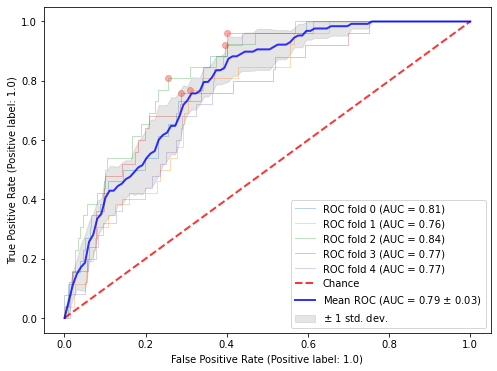

[0.8091195913461539, 0.7552584134615385, 0.8379657451923077, 0.7739062499999999, 0.7710937499999999]
0.7894687499999999
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8614     ,    0.8409     ,    0.8599     ,    0.3333     ,    0.4774     
  0  ,    0.8858     ,    0.7955     ,    0.8789     ,    0.3646     ,    0.5000     
  1  ,    0.8668     ,    0.8889     ,    0.8685     ,    0.3604     ,    0.5128     
  1  ,    0.8837     ,    0.8444     ,    0.8806     ,    0.3800     ,    0.5241     
  2  ,    0.8180     ,    0.9333     ,    0.8270     ,    0.3022     ,    0.4565     
  2  ,    0.8612     ,    0.7778     ,    0.8547     ,    0.3211     ,    0.4545     
  3  ,    0.9156     ,    0.7778     ,    0.9048     ,    0.4375     ,    0.5600     
  3  ,    0.8949     ,    0.7778     ,    0.8858     ,    0.3846     ,    0.5147     
  4  ,    0.8705     ,    0.9333     ,    0.8754     ,    0.3784     ,

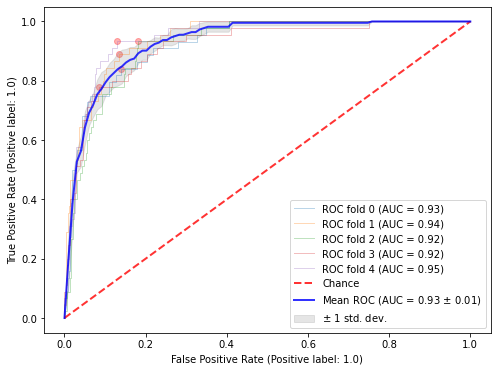

[0.9271365338781069, 0.9439649781113195, 0.9228267667292057, 0.9182405670210548, 0.9475922451532207]
0.9319522181785815
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9492     ,    0.9351     ,    0.9485     ,    0.4800     ,    0.6344     
  0  ,    0.9661     ,    0.8831     ,    0.9622     ,    0.5667     ,    0.6904     
  1  ,    0.9525     ,    0.9091     ,    0.9504     ,    0.4895     ,    0.6364     
  1  ,    0.9707     ,    0.8701     ,    0.9659     ,    0.5982     ,    0.7090     
  2  ,    0.9225     ,    0.8701     ,    0.9200     ,    0.3602     ,    0.5095     
  2  ,    0.9648     ,    0.7662     ,    0.9554     ,    0.5221     ,    0.6211     
  3  ,    0.8685     ,    0.8571     ,    0.8679     ,    0.2463     ,    0.3826     
  3  ,    0.9779     ,    0.7273     ,    0.9659     ,    0.6222     ,    0.6707     
  4  ,    0.9049     ,    0.8816     ,    0.9038     ,    0.3146     ,

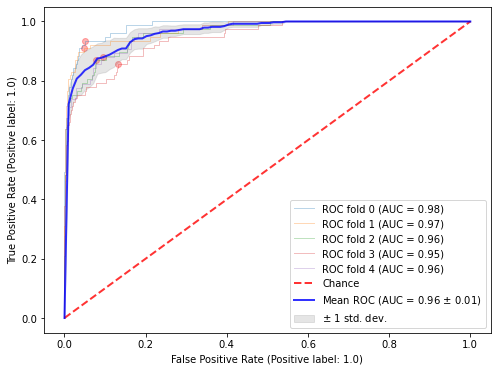

[0.9847470238095237, 0.9746939258658008, 0.9621803977272727, 0.945016571969697, 0.9639357182017544]
0.9661147275148098
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8625     ,    0.8846     ,    0.8649     ,    0.4381     ,    0.5860     
  0  ,    0.8485     ,    0.8846     ,    0.8524     ,    0.4144     ,    0.5644     
  1  ,    0.8473     ,    0.8558     ,    0.8482     ,    0.4045     ,    0.5494     
  1  ,    0.8578     ,    0.8077     ,    0.8524     ,    0.4078     ,    0.5419     
  2  ,    0.8578     ,    0.8173     ,    0.8534     ,    0.4106     ,    0.5466     
  2  ,    0.8613     ,    0.8077     ,    0.8555     ,    0.4138     ,    0.5472     
  3  ,    0.8203     ,    0.8462     ,    0.8231     ,    0.3636     ,    0.5087     
  3  ,    0.8413     ,    0.7981     ,    0.8366     ,    0.3790     ,    0.5139     
  4  ,    0.7550     ,    0.9327     ,    0.7742     ,    0.3160     , 

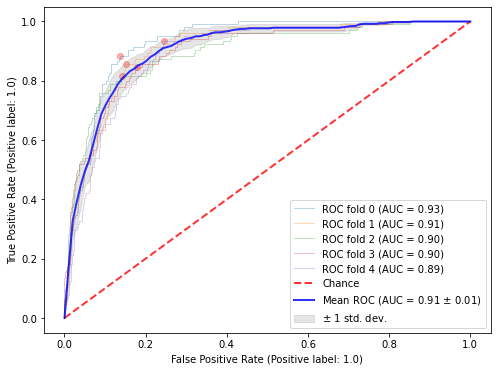

[0.9295992469069392, 0.9084633315402547, 0.8983884705038552, 0.9012319360919128, 0.8925926757023607]
0.9060551321490644
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9667     ,    0.9688     ,    0.9668     ,    0.6596     ,    0.7848     
  0  ,    0.9917     ,    0.8750     ,    0.9844     ,    0.8750     ,    0.8750     
  1  ,    0.9708     ,    0.9375     ,    0.9688     ,    0.6818     ,    0.7895     
  1  ,    0.9833     ,    0.8125     ,    0.9727     ,    0.7647     ,    0.7879     
  2  ,    0.9771     ,    1.0000     ,    0.9785     ,    0.7442     ,    0.8533     
  2  ,    0.9792     ,    0.9375     ,    0.9766     ,    0.7500     ,    0.8333     
  3  ,    0.9854     ,    1.0000     ,    0.9863     ,    0.8205     ,    0.9014     
  3  ,    0.9917     ,    0.9688     ,    0.9902     ,    0.8857     ,    0.9254     
  4  ,    0.9833     ,    1.0000     ,    0.9844     ,    0.8000     ,

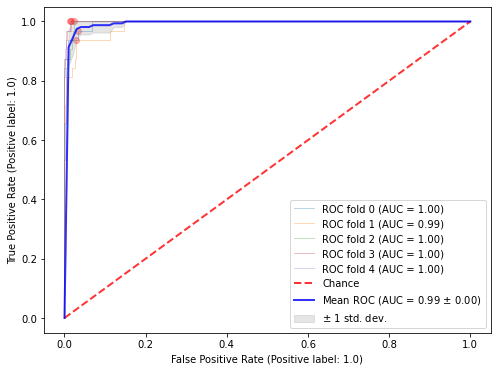

[0.9951171875, 0.9881510416666667, 0.9975911458333333, 0.9990885416666667, 0.9990234375]
0.9957942708333334
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    0.9818     ,    1.0000     ,    0.9867     ,    0.9524     ,    0.9756     
  1  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  2  ,    0.9818     ,    0.9500     ,    0.9733     ,    0.9500     ,    0.9500     
  2  ,    0.9818     ,    0.9000     ,    0.9600     ,    0.9474     ,    0.9231     
  3  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  3  ,    1.0000     ,    0.9500     ,    0.9867     ,    1.0000     ,    0.9744     
  4  ,    1.0000     ,    0.9474     ,    0.9865     ,    1.0000     ,    0.97

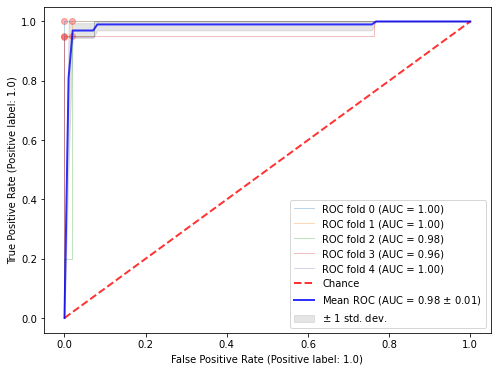

[1.0, 0.999090909090909, 0.9827272727272727, 0.9618181818181818, 0.9961722488038277]
0.9879617224880383
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9574     ,    1.0000     ,    0.9697     ,    0.9048     ,    0.9500     
  0  ,    1.0000     ,    0.8947     ,    0.9697     ,    1.0000     ,    0.9444     
  1  ,    0.9565     ,    1.0000     ,    0.9697     ,    0.9091     ,    0.9524     
  1  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  2  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  2  ,    1.0000     ,    0.8500     ,    0.9545     ,    1.0000     ,    0.9189     
  3  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    0.9783     ,    0.9500     ,    0.9697     ,    0.9500     ,    0.9500     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000  

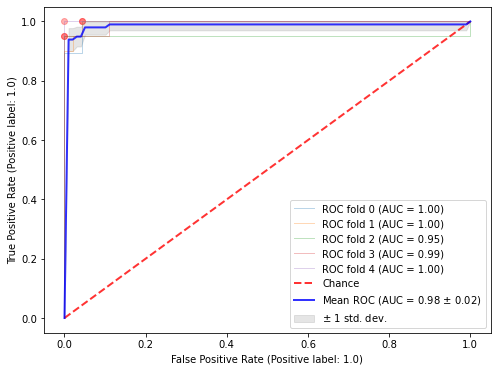

[0.9955207166853304, 0.9967391304347827, 0.95, 0.9945652173913043, 1.0]
0.9873650129022835


In [7]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred_lr(data_x, data_y,save=sample,dop="pred")
    print(aucs)
    print(np.mean(aucs))

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9722     ,    0.9916     ,    1.0000     ,    0.9859     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    0.9859     ,    0.9958     ,    1.0000     ,    0.9929     
              prec

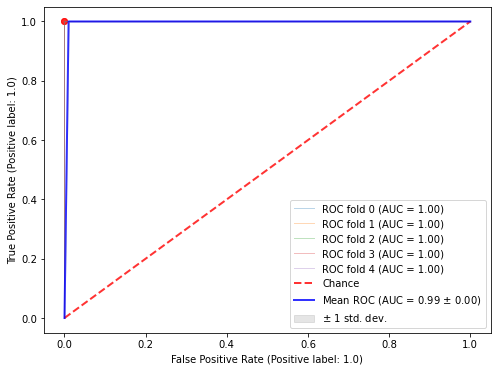

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    0.9869     ,    1.0000     ,    0.9886     ,    0.9200     ,    0.9583     
  1  ,    1.0000     ,    0.9710     ,    0.9962     ,    1.0000     ,    0.9853     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    

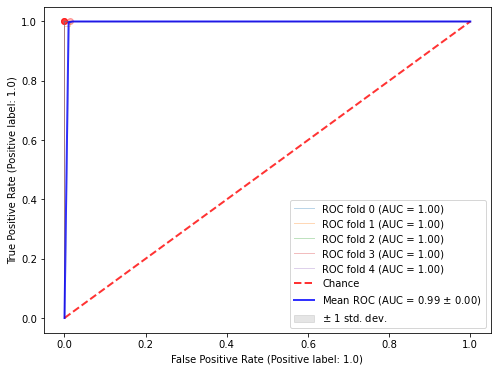

[1.0, 0.9998105522402199, 1.0, 1.0, 1.0]
0.999962110448044
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9937     ,    0.9896     ,    0.9933     ,    0.9406     ,    0.9645     
  0  ,    0.9926     ,    0.9896     ,    0.9924     ,    0.9314     ,    0.9596     
  1  ,    0.9932     ,    0.9740     ,    0.9914     ,    0.9350     ,    0.9541     
  1  ,    0.9947     ,    0.9688     ,    0.9924     ,    0.9490     ,    0.9588     
  2  ,    0.9953     ,    0.9844     ,    0.9943     ,    0.9545     ,    0.9692     
  2  ,    0.9963     ,    0.9740     ,    0.9943     ,    0.9639     ,    0.9689     
  3  ,    0.9942     ,    0.9740     ,    0.9924     ,    0.9444     ,    0.9590     
  3  ,    0.9974     ,    0.9635     ,    0.9943     ,    0.9737     ,    0.9686     
  4  ,    0.9921     ,    0.9792     ,    0.9909     ,    0.9261     ,    0.9519     
  4  ,    0.9958     ,    0.9635     ,    0.9

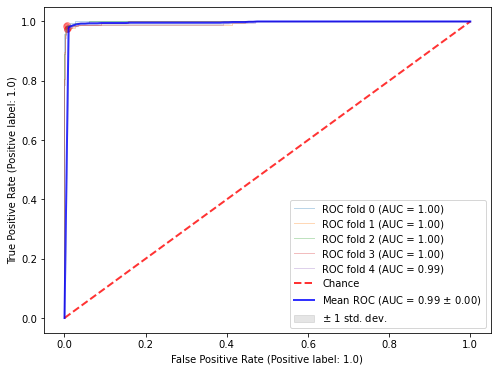

[0.9997073047969187, 0.9950378588935574, 0.9993489583333334, 0.9981863839285714, 0.9949202337184875]
0.9974401479341738
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9803     ,    0.9709     ,    0.9795     ,    0.8197     ,    0.8889     
  0  ,    0.9973     ,    0.9417     ,    0.9926     ,    0.9700     ,    0.9557     
  1  ,    0.9821     ,    0.9709     ,    0.9811     ,    0.8333     ,    0.8969     
  1  ,    0.9928     ,    0.9417     ,    0.9885     ,    0.9238     ,    0.9327     
  2  ,    0.9695     ,    1.0000     ,    0.9721     ,    0.7518     ,    0.8583     
  2  ,    0.9937     ,    0.9612     ,    0.9910     ,    0.9340     ,    0.9474     
  3  ,    0.9955     ,    0.9806     ,    0.9943     ,    0.9528     ,    0.9665     
  3  ,    0.9955     ,    0.9806     ,    0.9943     ,    0.9528     ,    0.9665     
  4  ,    0.9928     ,    0.9608     ,    0.9901     ,    0.9245     ,

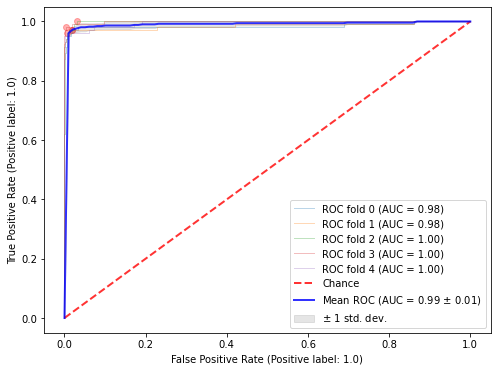

[0.9841667536625256, 0.9849236176358005, 0.998555868740648, 0.9987994571458398, 0.9950277602080257]
0.992294691478568
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000    

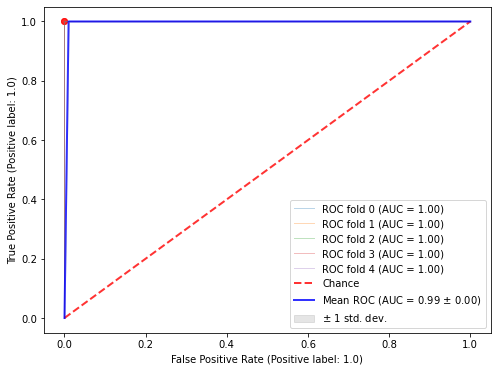

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9933     ,    0.9677     ,    0.9921     ,    0.8824     ,    0.9231     
  0  ,    0.9950     ,    0.9355     ,    0.9921     ,    0.9062     ,    0.9206     
  1  ,    0.9950     ,    0.9333     ,    0.9920     ,    0.9032     ,    0.9180     
  1  ,    0.9967     ,    0.9000     ,    0.9920     ,    0.9310     ,    0.9153     
  2  ,    0.9849     ,    1.0000     ,    0.9857     ,    0.7692     ,    0.8696     
  2  ,    1.0000     ,    0.9667     ,    0.9984     ,    1.0000     ,    0.9831     
  3  ,    0.9799     ,    1.0000     ,    0.9809     ,    0.7143     ,    0.8333     
  3  ,    0.9916     ,    0.9667     ,    0.9904     ,    0.8529     ,    0.9062     
  4  ,    0.9967     ,    0.9667     ,    0.9952     ,    0.9355     ,    0.9508     
  4  ,    0.9967     ,    0.9667     ,    0.9952     ,    0.9355     ,

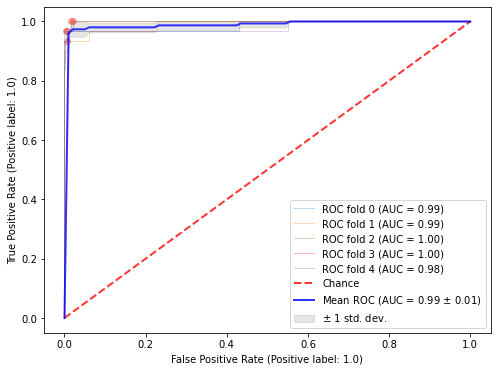

[0.9857589815514081, 0.9901895206243033, 0.9994983277591973, 0.9991638795986622, 0.9814381270903011]
0.9912097673247745
========== Patient_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9796     ,    1.0000     ,    0.9856     ,    0.9538     ,    0.9764     
  0  ,    0.9864     ,    0.9677     ,    0.9809     ,    0.9677     ,    0.9677     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9839     ,    0.9952     ,    1.0000     ,    0.9919     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9508     ,    0.9856     ,    1.0000     ,    0.9748     
  3  ,    0.9932     ,    0.9836     ,    0.9904     ,    0.9836     ,    0.9836     
  3  ,    0.9932     ,    0.9672     ,    0.9856     ,    0.9833     ,    0.9752     
  4  ,    0.9796     ,    0.9836     ,    0.9808     ,    0.9524  

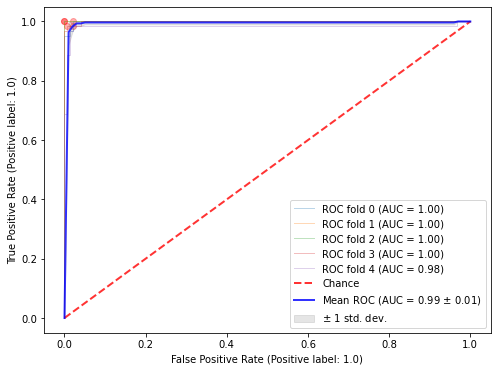

[0.9991222295369762, 1.0, 1.0, 0.9992193598750976, 0.9813761570201851]
0.9959435492864518
========== Patient_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    

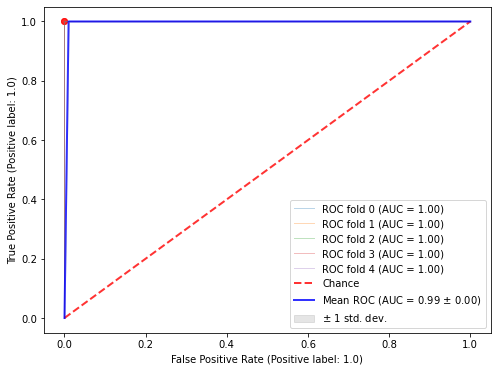

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9615     ,    0.9982     ,    1.0000     ,    0.9804     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    0.9905     ,    1.0000     ,    0.9909     ,    0.8333     ,    0.9091     
  3  ,    0.9981     ,    0.9200     ,    0.9945     ,    0.9583     ,    0.9388     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

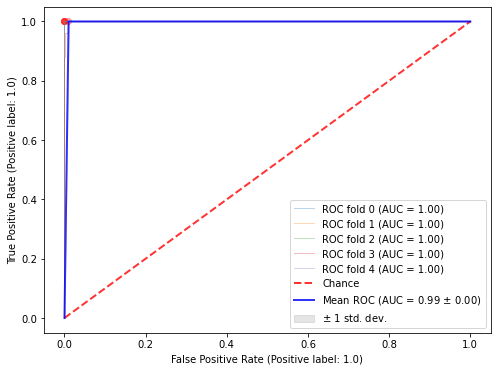

[1.0, 1.0, 1.0, 0.9994656488549619, 1.0]
0.9998931297709923
========== Patient_6_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9964     ,    1.0000     ,    0.9967     ,    0.9574     ,    0.9783     
  0  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  2  ,    1.0000     ,    0.9556     ,    0.9967     ,    1.0000     ,    0.9773     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    0.9778     ,    0.9983     ,    1.0000     ,    0.9888     
  4  ,    0.9982     ,    1.0000     ,    0.9983     ,    0.9783     ,    0.9890     
  4  ,    0.9982     ,    1.0000     ,  

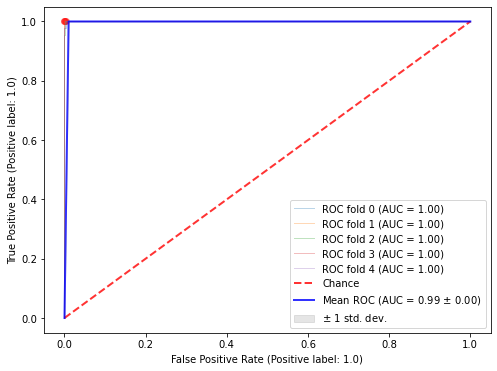

[0.9999199199199199, 1.0, 0.9999197753710389, 1.0, 0.9999598876855195]
0.9999599165952956
========== Patient_7_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9985     ,    1.0000     ,    0.9986     ,    0.9828     ,    0.9913     
  0  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9825     ,    0.9986     ,    1.0000     ,    0.9912     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9821     ,    0.9986     ,    1.0000     ,    0.9910     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    0.9969     ,    1.0000     ,    0.9972     ,    0.9655     ,    0.9825     
  4  ,    

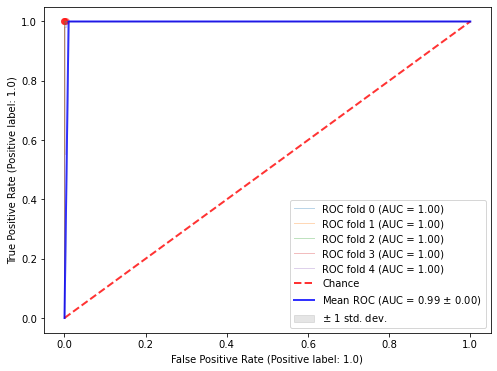

[0.9999729261425168, 1.0, 1.0, 1.0, 0.9992835097001763]
0.9998512871685387
========== Patient_8_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9912     ,    0.9444     ,    0.9868     ,    0.9189     ,    0.9315     
  0  ,    0.9912     ,    0.9444     ,    0.9868     ,    0.9189     ,    0.9315     
  1  ,    0.9883     ,    1.0000     ,    0.9894     ,    0.9000     ,    0.9474     
  1  ,    0.9912     ,    0.9444     ,    0.9868     ,    0.9189     ,    0.9315     
  2  ,    0.9971     ,    0.9722     ,    0.9947     ,    0.9722     ,    0.9722     
  2  ,    0.9942     ,    0.9722     ,    0.9921     ,    0.9459     ,    0.9589     
  3  ,    1.0000     ,    0.9722     ,    0.9974     ,    1.0000     ,    0.9859     
  3  ,    0.9708     ,    0.9722     ,    0.9709     ,    0.7778     ,    0.8642     
  4  ,    0.9942     ,    0.8611     ,    0.9815     ,    0.9394     ,    0.8986     
  4  ,    0.9942     ,   

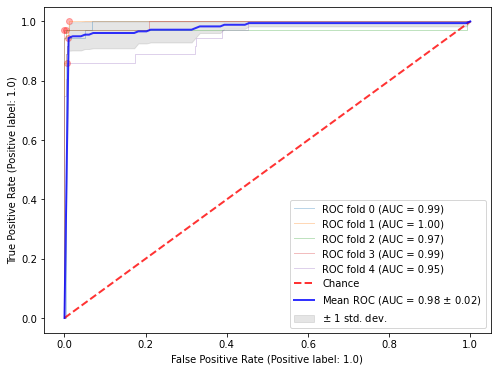

[0.9937459389213775, 0.9989441195581547, 0.9723846653671214, 0.9942332683560753, 0.9533788174139052]
0.9825373619233269


In [8]:
file_list = [f for f in Path(dect_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred_lr(data_x, data_y,save=sample,dop="dect")
    print(aucs)
    print(np.mean(aucs))